### **Descarga e importe de bibliotecas**

In [1]:
%%capture
!pip install git+https://github.com/qubvel/classification_models.git

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

In [5]:
import gc
import re
import glob
import random
import shutil
import zipfile
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras as keras
import tf_keras.backend as K
from tf_keras.losses import Loss
from tf_keras.layers import Layer
from tf_keras import layers, Model
from tf_keras.optimizers import Adam
from tf_keras.callbacks import Callback
from tf_keras.saving import register_keras_serializable

# ResUNet Model Backbone
from classification_models.tfkeras import Classifiers  # Requires: pip install git+https://github.com/qubvel/classification_models.git

### **Configuración del entorno**

In [7]:
# Set a seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [8]:
# Create a distribution strategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


### **Descarga y cargado de la base de datos de semillas**

##### **Importante definir el número de clases**

In [9]:
classes = 2 # Son dos clases; 0-Fondo, 1-feet

In [16]:
# Download histology dataset
classes_ = {2:1}
!kaggle datasets download fredycastao/Mamitas/{classes_[classes]}

os.makedirs('./datasets/Mamitas', exist_ok=True)
with zipfile.ZipFile('./Mamitas.zip', 'r') as zip_ref: zip_ref.extractall('./datasets/Mamitas')
!rm -rf ./Mamitas.zip

Dataset URL: https://www.kaggle.com/datasets/fredycastao/Mamitas/versions/1
License(s): CC-BY-SA-4.0
 99%|██████████████████████████████████████▋| 78.0M/78.6M [00:00<00:00, 272MB/s]
100%|███████████████████████████████████████| 78.6M/78.6M [00:00<00:00, 267MB/s]


In [17]:
config = {"Seg_model":"ResUNet","Activation":"softmax","Input size":(512,512,3),"Image size":(512,512),
          "Dataset":"Mamitas","Dir of dataset":"./datasets/Mamitas","Batch size":32,"Epochs":60,"Number of classes":classes}

In [18]:
class DataLoader:

    def __init__(self, data_dir, batch_size, image_size, num_classes, partition):

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.partition = partition

    def load_images(self):

        # Create the path for patch images
        images_path_pattern = os.path.join(self.data_dir, self.partition, 'images', '*.png')
        images_files = glob.glob(images_path_pattern)

        # Sort patch files alphanumerically
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers for proper sorting
            return [int(part) if part.isdigit() else part for part in parts]

        images_files = sorted(images_files, key=alphanumeric_key)

        self.file_sample = []
        for file in images_files:
            name_file = file.split('/')[-1]
            self.file_sample.append(name_file)

        self.num_samples = len(images_files)

        # Print the complete path and the number of found patch images
        print(f"Complete images: {images_path_pattern}")
        print(f"Number of images files found: {len(images_files)}")

        # Create a TensorFlow dataset from the images file paths
        images_ds = tf.data.Dataset.from_tensor_slices(images_files)

        # Map each file path to a processed image
        images_ds = images_ds.map(self.process_images, num_parallel_calls=tf.data.AUTOTUNE)

        return images_ds

    def load_masks(self):

        mask_path_main = os.path.join(self.data_dir, self.partition, 'masks')

        # Check samples in classes
        for class_id in range(self.num_classes):
            mask_path_pattern = os.path.join(mask_path_main, f'class_{class_id}', '*.png')
            found_masks = glob.glob(mask_path_pattern)
            print(f"Original masks path, class {class_id}: {mask_path_pattern}")
            print(f"Number of masks found: {len(found_masks)}")

        masks_path = []
        # Organize ground truth masks by sample and class
        for sample in self.file_sample:
            masks_sample = []
            for class_id in range(self.num_classes):
                masks_sample.append(os.path.join(mask_path_main, f'class_{class_id}', sample))
            masks_path.append(masks_sample)

        # Create dataset from `masks_path` and apply `process_masks` to each set of paths
        masks_ds = tf.data.Dataset.from_tensor_slices(masks_path)
        masks_ds = masks_ds.map(self.process_masks, num_parallel_calls=tf.data.AUTOTUNE)

        return masks_ds

    def process_images(self, file_path):

        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_png(img, channels=3)  # Decode PNG image
        img = tf.image.resize(img, self.image_size)  # Resize image
        img = tf.cast(img, tf.float32)  # Convert to float32
        img /= 255.0  # Normalize to [0, 1]
        return img

    def process_masks(self, sample_paths):

        # Decode and process images
        decoded_images = tf.map_fn(
            tf.io.read_file,
            sample_paths,
            dtype=tf.string,
            parallel_iterations=4
        )

        masks = tf.map_fn(
            lambda x: tf.io.decode_png(x, channels=1),
            decoded_images,
            dtype=tf.uint8,
            parallel_iterations=4
        )

        # Resize and normalize
        masks = tf.map_fn(
            lambda x: tf.image.resize(x, size=self.image_size),
            masks,
            dtype=tf.float32
        )

        masks = tf.cast(masks, tf.float32)  # Convert to float32
        masks = masks / 255.0  # Normalize to [0, 1]
        masks = tf.squeeze(masks, axis=-1)  # Remove the last dimension
        masks = tf.transpose(masks, perm=[1, 2, 0])  # Transpose to [height, width, classes]

        return masks

    def get_dataset(self):

        images_ds = self.load_images()
        masks_ds = self.load_masks()
        dataset = tf.data.Dataset.zip((images_ds,masks_ds))

        # Apply batching and prefetching for optimization
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [19]:
# Instantiate data loader and load train partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Train')
train_dataset = data_loader.get_dataset()

Complete images: ./datasets/Mamitas/Train/images/*.png
Number of images files found: 384
Original masks path, class 0: ./datasets/Mamitas/Train/masks/class_0/*.png
Number of masks found: 384
Original masks path, class 1: ./datasets/Mamitas/Train/masks/class_1/*.png
Number of masks found: 384


In [20]:
# Instantiate data loader and load validation partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Valid')
valid_dataset = data_loader.get_dataset()

Complete images: ./datasets/Mamitas/Valid/images/*.png
Number of images files found: 30
Original masks path, class 0: ./datasets/Mamitas/Valid/masks/class_0/*.png
Number of masks found: 30
Original masks path, class 1: ./datasets/Mamitas/Valid/masks/class_1/*.png
Number of masks found: 30


In [21]:
# Instantiate data loader and load test partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Test')
test_dataset = data_loader.get_dataset()

Complete images: ./datasets/Mamitas/Test/images/*.png
Number of images files found: 30
Original masks path, class 0: ./datasets/Mamitas/Test/masks/class_0/*.png
Number of masks found: 30
Original masks path, class 1: ./datasets/Mamitas/Test/masks/class_1/*.png
Number of masks found: 30


#### **Visualización de la base de datos de semillas**

In [22]:
def random_sample_visualization(dataset, num_classes):

    # Select first batch
    batch = 0

    # Skip to the desired batch and take one batch
    for images, masks in dataset.skip(batch).take(1):
        print(f"Images in the batch: {images.shape}, Masks in the batch: {masks.shape}")

    # Select a random sample within the batch
    sample = random.randint(0, images.shape[0]-1)

    # Determine the number of columns for the visualization grid
    columns = []
    rows = 2

    columns.append(masks.shape[-1] if masks.shape[-1] <= 6 else 6)

    columns = max(columns)

    fig = plt.figure(figsize=(20, 12))
    
    gs = fig.add_gridspec(rows + 1, columns, hspace=0.2, wspace=-0.6)
    axes = [[fig.add_subplot(gs[r, c]) for c in range(columns)] for r in range(rows)]

    # Display the original image for the selected sample
    axes[0][0].set_title('Image',loc='center')
    axes[0][0].imshow(images[sample])  # Show the sample image

    title_ax = fig.add_subplot(gs[rows-1, :])
    title_ax.set_title("Masks of segmentation for different classes",loc='left')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(num_classes,columns):
        num = random.randint(0, num_classes-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-1][i].imshow(masks[sample, :, :, classes_list[i]:classes_list[i]+1])

    [ax.axis('off') for row in axes for ax in row]

    # Adjust layout for better spacing
    fig.tight_layout()

    # Display the visualization
    plt.show()

    # Free memory
    del images, masks # Delete large variables
    if 'annotators_list' in locals():
        del annotators_list
    if 'classes_list' in locals():
        del classes_list
    gc.collect() # Force garbage collection

Images in the batch: (32, 512, 512, 3), Masks in the batch: (32, 512, 512, 2)


<ipython-input-22-bf66a0e7f52d>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


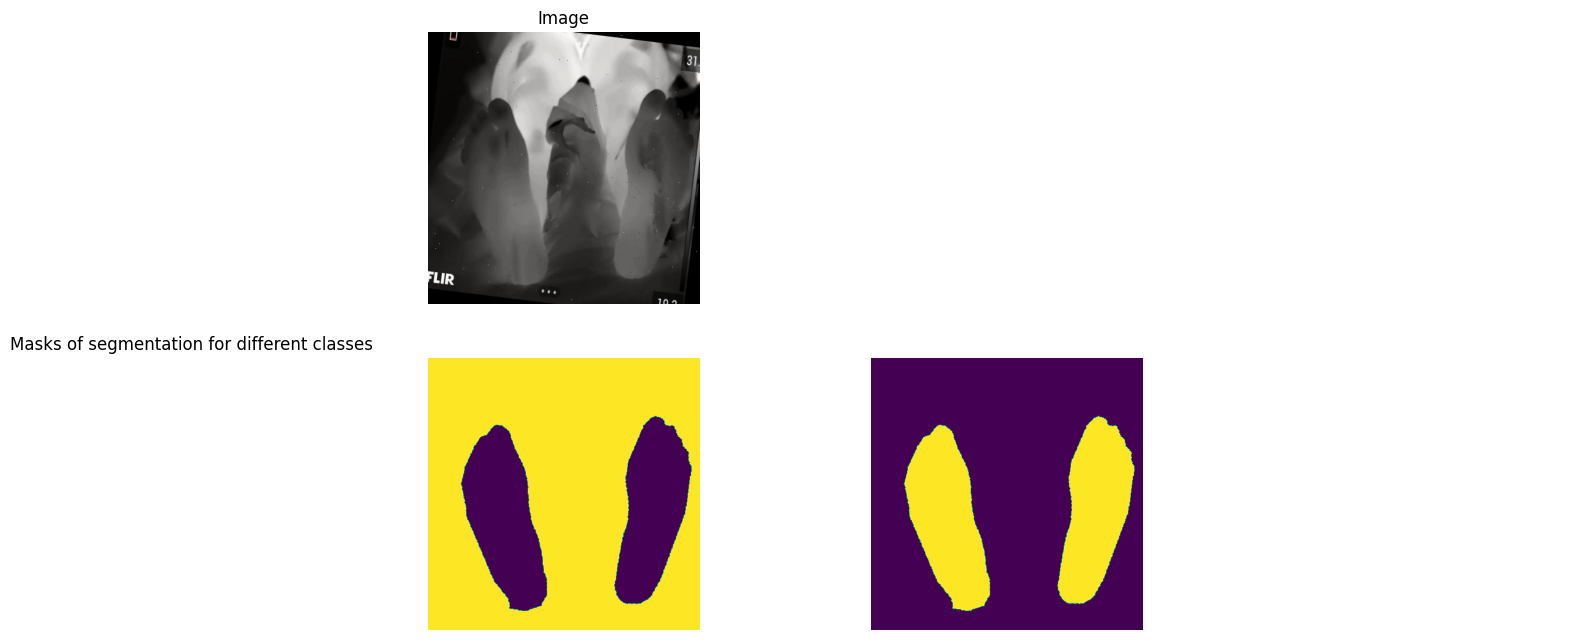

In [23]:
random_sample_visualization(train_dataset, config['Number of classes'])

### **Definición y creación del modelo, medidas de rendimiento y función de pérdida**

In [24]:
ResNet34, preprocess_input = Classifiers.get('resnet34')

# Definition of layers for the neural network structure

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)


upsample = partial(layers.UpSampling2D, (2,2))

@register_keras_serializable(package="my_custom_losses")
class DiceCoefficient(Loss):
    def __init__(self, smooth=1., target_class= None, name='DiceCoefficient', **kwargs):
        self.smooth = smooth
        self.target_class = target_class
        super().__init__(name=name,**kwargs)

    def call(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)
        
        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

@register_keras_serializable(package="my_custom_metrics")
def dice_metric(y_true, y_pred, smooth=1e-7, axis=(1, 2), return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)

    if return_mean:
        return tf.reduce_mean(dice)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if dice.shape[1] > 1:
            return tf.transpose(dice, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(dice, perm=[1, 0]), axis=0)
            
@register_keras_serializable(package="my_custom_metrics")
def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    if return_mean:
        return tf.reduce_mean(jaccard)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if jaccard.shape[1] > 1:
            return tf.transpose(jaccard, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(jaccard, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def sensitivity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    actual_positives = tf.reduce_sum(y_true, axis=axis)
    sensitivity = true_positives / (actual_positives + smooth)
    if return_mean:
        return tf.reduce_mean(sensitivity)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if sensitivity.shape[1] > 1:
            return tf.transpose(sensitivity, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(sensitivity, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def specificity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=axis)
    actual_negatives = tf.reduce_sum(1 - y_true, axis=axis)
    specificity = true_negatives / (actual_negatives + tf.keras.backend.epsilon())
    if return_mean:
        return tf.reduce_mean(specificity)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if specificity.shape[1] > 1:
            return tf.transpose(specificity, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(specificity, perm=[1, 0]), axis=0)


@register_keras_serializable(package="my_custom_activations")
def sparse_softmax(x):
    
    e_x = tf.exp(x - tf.reduce_max(x, axis=-1, keepdims=True))
    sum_e_x = tf.reduce_sum(e_x, axis=-1, keepdims=True)
    output = e_x / (sum_e_x + keras.backend.epsilon())
    return output

def kernel_initializer(seed):
    
    return tf.keras.initializers.GlorotUniform(seed=seed)


def residual_block(x, filters, kernel_initializer, block_name):
    
    shortcut = x
    x = DefaultConv2D(filters, kernel_initializer=kernel_initializer, name=f'Conv_{block_name}_1')(x)
    x = layers.BatchNormalization(name=f'Batch_{block_name}_1')(x)
    x = DefaultConv2D(filters, kernel_initializer=kernel_initializer, name=f'Conv_{block_name}_2')(x)
    x = layers.BatchNormalization(name=f'Batch_{block_name}_2')(x)
    x = layers.Add(name=f'ResAdd_{block_name}')([shortcut, x])
    x = layers.Activation('relu', name=f'ResAct_{block_name}')(x)
    return x

def UNet(inputs, out_channels, activation):
    
    # Encoder - Downsampling path with increasing filter numbers
    # Each level follows: Conv -> Dropout -> BatchNorm -> Conv -> Dropout -> BatchNorm -> Pooling

    x = layers.BatchNormalization(name='Batch00')(inputs)
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(34), name='Conv10')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch10')(x)
    x = level_1 = DefaultConv2D(8, kernel_initializer=kernel_initializer(4), name='Conv11')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch11')(x)
    x = DefaultPooling(name='Pool10')(x)  # 128x128 -> 64x64

    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(56), name='Conv20')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch20')(x)
    x = level_2 = DefaultConv2D(16, kernel_initializer=kernel_initializer(32), name='Conv21')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch22')(x)
    x = DefaultPooling(name='Pool20')(x)  # 64x64 -> 32x32

    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(87), name='Conv30')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch30')(x)
    x = level_3 = DefaultConv2D(32, kernel_initializer=kernel_initializer(30), name='Conv31')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch31')(x)
    x = DefaultPooling(name='Pool30')(x)  # 32x32 -> 16x16

    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(79), name='Conv40')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch40')(x)
    x = level_4 = DefaultConv2D(64, kernel_initializer=kernel_initializer(81), name='Conv41')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch41')(x)
    x = DefaultPooling(name='Pool40')(x)  # 16x16 -> 8x8

    # Decoder - Upsampling path with decreasing filter numbers
    # Each level follows: Conv -> Dropout -> BatchNorm -> Conv -> Dropout -> BatchNorm
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(89), name='Conv50')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch50')(x)
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(42), name='Conv51')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch51')(x)

    # Upsampling and skip connection with level_4 features
    x = upsample(name='Up60')(x)  # 8x8 -> 16x16
    x = layers.Concatenate(name='Concat60')([level_4, x])
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(91), name='Conv60')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch60')(x)
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(47), name='Conv61')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch61')(x)

    # Upsampling and skip connection with level_3 features
    x = upsample(name='Up70')(x)  # 16x16 -> 32x32
    x = layers.Concatenate(name='Concat70')([level_3, x])
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(21), name='Conv70')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch70')(x)
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(96), name='Conv71')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch71')(x)

    # Upsampling and skip connection with level_2 features
    x = upsample(name='Up80')(x)  # 32x32 -> 64x64
    x = layers.Concatenate(name='Concat80')([level_2, x])
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(96), name='Conv80')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch80')(x)
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(98), name='Conv81')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch81')(x)

    # Upsampling and skip connection with level_1 features
    x = upsample(name='Up90')(x)  # 64x64 -> 128x128
    x = layers.Concatenate(name='Concat90')([level_1, x])
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(35), name='Conv90')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch90')(x)
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(7), name='Conv91')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch91')(x)

    # Final segmentation output with specified activation
    if activation == 'sparse_softmax':
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=sparse_softmax,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)
    else:
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=activation,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)

    return x


def ResUNet(inputs, input_shape, out_channels,activation):
    
    # Backbone (ResNet34) - Use pre-trained weights from ImageNet
    backbone = ResNet34(
        input_shape=input_shape,
        input_tensor=inputs,
        include_top=False,
        weights='imagenet')

    # Freeze backbone layers except BatchNormalization layers
    # This allows the model to adapt to the new domain while retaining learned features
    for layer in backbone.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    # Extract feature maps from different levels of the ResNet backbone
    level_1 = backbone.layers[5].output   # 128x128x64
    level_2 = backbone.layers[37].output  # 64x64x64
    level_3 = backbone.layers[74].output  # 32x32x128
    level_4 = backbone.layers[129].output # 16x16x256
    x = backbone.layers[157].output       # 8x8x512

    # Decoder - Upsampling path with skip connections to encoder features
    # First upsampling block
    x = upsample(name='Up60')(x)
    x = layers.Concatenate(name='Concat60')([level_4, x])
    x = DefaultConv2D(256, kernel_initializer=kernel_initializer(91) , name='Conv60')(x)
    x = residual_block(x, 256, kernel_initializer(47), '60')  # Apply residual block

    # Second upsampling block
    x = upsample(name='Up70')(x)
    x = layers.Concatenate(name='Concat70')([level_3, x])
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(21), name='Conv70')(x)
    x = residual_block(x, 128, kernel_initializer(96), '70')  # Apply residual block

    # Third upsampling block
    x = upsample(name='Up80')(x)
    x = layers.Concatenate(name='Concat80')([level_2, x])
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(96), name='Conv80')(x)
    x = residual_block(x, 64, kernel_initializer(98), '80')  # Apply residual block

    # Fourth upsampling block
    x = upsample(name='Up90')(x)
    x = layers.Concatenate(name='Concat90')([level_1, x])
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(35), name='Conv90')(x)
    x = residual_block(x, 32, kernel_initializer(7), '90')  # Apply residual block

    # Final upsampling block - connect back to input
    x = upsample(name='Up100')(x)
    x = layers.Concatenate(name='Concat100')([inputs, x])
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(45), name='Conv100')(x)
    x = residual_block(x, 16, kernel_initializer(7), '100')  # Apply residual block

    # Final segmentation output with specified activation
    if activation == 'sparse_softmax':
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=sparse_softmax,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)
    else:
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=activation,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)

    return x

def Seg_Model(class_no=2, input_shape=(512, 512, 3), seg_model='ResUNet', activation='softmax'):
    
    # Input layer definition
    image_input = layers.Input(shape=input_shape, name='image_input')

    # Select and build the appropriate segmentation backbone
    if seg_model == 'ResUNet':
        # Use ResNet-based UNet architecture
        seg_rm = ResUNet(image_input, input_shape, out_channels=class_no, activation=activation)
    elif seg_model == 'UNet':
        # Use standard UNet architecture
        seg_rm = UNet(image_input, out_channels=class_no, activation=activation)
    else:
        # Raise error for unsupported model types
        raise ValueError(f"Unsupported segmentation model type: {seg_model}. Supported models are 'ResUNet' and 'UNet'.")

    # Create and return the final model
    return Model(image_input, seg_rm, name=seg_model)

In [25]:
with strategy.scope():
    model = Seg_Model(class_no=config['Number of classes'],input_shape=config['Input size'], 
                 seg_model=config['Seg_model'], activation=config['Activation'])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss=DiceCoefficient(smooth=1e-7, target_class=None if config['Number of classes'] == 3 else 1),
                  metrics=[dice_metric,jaccard_metric,sensitivity_metric,specificity_metric])

85521592/85521592 [==============================] - 1s 0us/step


### **Entrenamiento de la base de datos**

In [35]:
class CustomLearningRateScheduler(Callback):
    def __init__(self, new_lr, epoch_to_change):
        super(CustomLearningRateScheduler, self).__init__()
        self.new_lr = new_lr
        self.epoch_to_change = epoch_to_change

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.epoch_to_change:
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.new_lr)
            print(f"Learning rate changed to {self.new_lr} at epoch {epoch}") 

lr_scheduler = CustomLearningRateScheduler(1e-5, 30)
history = model.fit(train_dataset, epochs=config['Epochs'], validation_data=(valid_dataset), callbacks=[lr_scheduler])

Epoch 1/60
12/12 [==============================] - 20s 2s/step - loss: -0.9918 - dice_metric: 0.9950 - jaccard_metric: 0.9902 - sensitivity_metric: 0.9953 - specificity_metric: 0.9953 - val_loss: -0.7701 - val_dice_metric: 0.8547 - val_jaccard_metric: 0.7721 - val_sensitivity_metric: 0.8606 - val_specificity_metric: 0.8606
Epoch 2/60
12/12 [==============================] - 22s 2s/step - loss: -0.9918 - dice_metric: 0.9951 - jaccard_metric: 0.9902 - sensitivity_metric: 0.9953 - specificity_metric: 0.9953 - val_loss: -0.7839 - val_dice_metric: 0.8629 - val_jaccard_metric: 0.7831 - val_sensitivity_metric: 0.8689 - val_specificity_metric: 0.8689
Epoch 3/60
12/12 [==============================] - 19s 2s/step - loss: -0.9918 - dice_metric: 0.9951 - jaccard_metric: 0.9903 - sensitivity_metric: 0.9954 - specificity_metric: 0.9954 - val_loss: -0.7966 - val_dice_metric: 0.8705 - val_jaccard_metric: 0.7933 - val_sensitivity_metric: 0.8770 - val_specificity_metric: 0.8770
Epoch 4/60
12/12 [====

In [36]:
model.save(f"{config['Seg_model']}_{config['Activation']}_{config['Dataset']}.keras")

### **Desempeño del modelo**

#### **Visualización de las inferencias del modelo**

In [37]:
def performance_visualization(dataset, model, config):

    # Select a random batch index
    batch = 0

    # Skip to the desired batch and take one batch
    for images, masks in dataset.skip(batch).take(1):
        print(f"Images in the batch: {images.shape}, Masks in the batch: {masks.shape}")

    # Select a random sample within the batch
    sample = random.randint(0, images.shape[0]-1)

    predictions = model(images[sample:sample+1,...], training=False)

    # Determine the number of columns for the visualization grid

    columns = []
    rows = 3

    columns.append(masks.shape[-1] if masks.shape[-1] <= 6 else 6)
    
    columns = max(columns)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(rows + 1, columns, hspace=0.2, wspace=-0.6)
    axes = [[fig.add_subplot(gs[r, c]) for c in range(columns)] for r in range(rows)]

    # Display the original image for the selected sample
    axes[0][0].set_title('Image',loc='center')
    axes[0][0].imshow(images[sample])  # Show the sample image

    title_ax = fig.add_subplot(gs[rows-2, :])
    title_ax.set_title("Original masks of segmentation for different classes",loc='center')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(config['Number of classes'],columns):
        num = random.randint(0, config['Number of classes']-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-2][i].imshow(masks[sample, :, :,classes_list[i]:classes_list[i]+1])

    title_ax = fig.add_subplot(gs[rows-1, :])
    title_ax.set_title("Predicted masks of segmentation for different classes",loc='center')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(config['Number of classes'],columns):
        num = random.randint(0, config['Number of classes']-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-1][i].imshow(tf.where(predictions[0, :, :,classes_list[i]:classes_list[i]+1] >0.5, 1.0, 0.0))

    [ax.axis('off') for row in axes for ax in row]

    # Adjust layout for better spacing
    fig.tight_layout()

    # Display the visualization
    plt.show()
    # Free memory
    del images, predictions, classes_list, masks# Delete large variables
    gc.collect() # Force garbage collection

Images in the batch: (30, 512, 512, 3), Masks in the batch: (30, 512, 512, 2)


<ipython-input-37-8da1dc506d2d>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


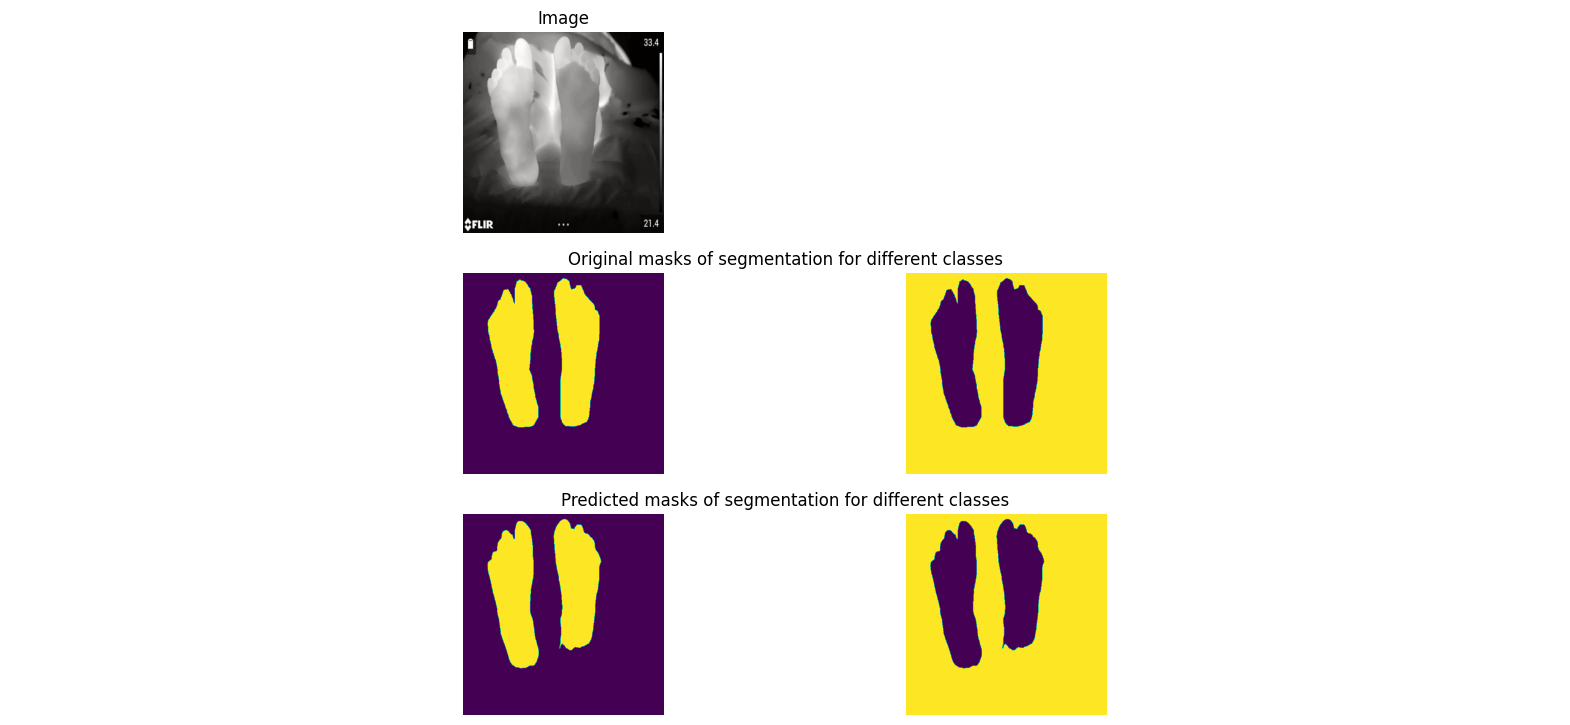

In [42]:
performance_visualization(test_dataset, model, config)

#### **Rendimiento del modelo para datos de evaluación**

In [39]:
def performance_measures(model,dataset,config,save_results=True):

    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # Initialize empty lists to store metric results
        dice_results = []
        jaccard_results = []
        sensitivity_results = []
        specificity_results = []

        # Process each batch in the dataset
        for data_batch in dataset:
            images, masks = data_batch

            # Generate model predictions
            y_pred = model(images, training=False)

            # Assume the model's prediction covers all classes
            y_pred_class = y_pred[...,:config['Number of classes']]
            dice_batch = dice_metric(masks, y_pred_class, return_mean=False)
            jaccard_batch = jaccard_metric(masks, y_pred_class, return_mean=False)
            sensitivity_batch = sensitivity_metric(masks, y_pred_class, return_mean=False)
            specificity_batch = specificity_metric(masks, y_pred_class, return_mean=False)
            
            # Store results from the current batch
            dice_results.append(dice_batch.numpy().flatten())
            jaccard_results.append(jaccard_batch.numpy().flatten())
            sensitivity_results.append(sensitivity_batch.numpy().flatten())
            specificity_results.append(specificity_batch.numpy().flatten())

            # Free memory by deleting unnecessary tensors immediately
            del y_pred, y_pred_class, dice_batch, jaccard_batch, sensitivity_batch, specificity_batch, images, masks

        # Convert lists of batches to flat NumPy arrays for analysis
        dice_results = np.concatenate(dice_results)
        jaccard_results = np.concatenate(jaccard_results)
        sensitivity_results = np.concatenate(sensitivity_results)
        specificity_results = np.concatenate(specificity_results)

        # Print performance summaries with 5 decimal places precision
        print("Model's performance metrics:")
        print(f"Dice Coefficient mean: {np.mean(dice_results):.5f}, standard deviation: {np.std(dice_results):.5f}")
        print(f"Jaccard Index mean: {np.mean(jaccard_results):.5f}, standard deviation: {np.std(jaccard_results):.5f}")
        print(f"Sensitivity mean: {np.mean(sensitivity_results):.5f}, standard deviation: {np.std(sensitivity_results):.5f}")
        print(f"Specificity mean: {np.mean(specificity_results):.5f}, standard deviation: {np.std(specificity_results):.5f}")

        # Save results to disk if requested
        if save_results:
            # Check if the directory exists, and if not, create it
            if not os.path.exists('./results'):
                os.makedirs('./results')

            # Generate filenames using the configuration parameters
            filename_base = f"./results/{config['Seg_model']}_{config['Activation']}_{config['Dataset']}"
            np.save(f"{filename_base}_DICE.npy", dice_results)
            np.save(f"{filename_base}_Jaccard.npy", jaccard_results)
            np.save(f"{filename_base}_Sensitivity.npy", sensitivity_results)
            np.save(f"{filename_base}_Specificity.npy", specificity_results)

        # Cleanup intermediate results to free memory
        gc.collect()
        del dice_results, jaccard_results, sensitivity_results, specificity_results
        return [f"{filename_base}_DICE.npy", f"{filename_base}_Jaccard.npy", f"{filename_base}_Sensitivity.npy", f"{filename_base}_Specificity.npy"]


In [40]:
metrics = performance_measures(model,test_dataset,config,save_results=True)

Model's performance metrics:
Dice Coefficient mean: 0.97410, standard deviation: 0.02505
Jaccard Index mean: 0.95062, standard deviation: 0.04528
Sensitivity mean: 0.97275, standard deviation: 0.03113
Specificity mean: 0.97275, standard deviation: 0.03113
